In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.large_repr = 'truncate'
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [18]:
def load_csv(relpath: str, has_id_col: bool=False) -> pd.DataFrame(): 
    if has_id_col:
        return pd.read_csv(relpath, index_col='id')
    else:
        return pd.read_csv(relpath)

df_investments = load_csv('./input_data/investments.csv.zip', True)
df_founding_rounds = load_csv('./input_data/funding_rounds.csv.zip', True)
df_objects = load_csv('./input_data/objects.csv.zip')

/var/folders/_c/hwg59c6j05bg6k4jldfcx44r0000gn/T/ipykernel_51510/2111064561.py:5: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(relpath)


In [19]:
def merge_investments(df: pd.DataFrame()=df_investments,                 
                      df_obj: pd.DataFrame()=df_objects,
                      df_fr: pd.DataFrame()=df_founding_rounds) -> pd.DataFrame():
    '''
    A function that merges df_investments with subsets of df_objects 
    and df_funding_rounds
    '''
    df_obj_fin = df_obj.query("`entity_type`=='FinancialOrg'")
    df_obj_comp = df_obj.query("`entity_type`=='Company'")
    return (df
            # merge with financial org subset
            .merge(df_obj_fin, how='inner', 
                   left_on='investor_object_id',
                   right_on='id', suffixes=['_investmens', '_investor_obj'])
            # merge with company subset
            .merge(df_obj_comp, how='inner', 
                   left_on='funded_object_id',
                   right_on='id', suffixes=['_investor_obj', '_obj_comp'])
            # merge with df_founding_rounds
            .merge(df_fr, how='inner', on='funding_round_id',
                   suffixes=['_obj', '_fr'])
           )

df_inv_raw = merge_investments()
df_inv_raw

,funding_round_id,funded_object_id,investor_object_id,created_at_investmens,updated_at_investmens,id_investor_obj,entity_type_investor_obj,entity_id_investor_obj,parent_id_investor_obj,name_investor_obj,normalized_name_investor_obj,permalink_investor_obj,category_code_investor_obj,status_investor_obj,founded_at_investor_obj,closed_at_investor_obj,domain_investor_obj,homepage_url_investor_obj,twitter_username_investor_obj,logo_url_investor_obj,logo_width_investor_obj,logo_height_investor_obj,short_description_investor_obj,description_investor_obj,overview_investor_obj,tag_list_investor_obj,country_code_investor_obj,state_code_investor_obj,city_investor_obj,region_investor_obj,first_investment_at_investor_obj,last_investment_at_investor_obj,investment_rounds_investor_obj,invested_companies_investor_obj,first_funding_at_investor_obj,last_funding_at_investor_obj,funding_rounds_investor_obj,funding_total_usd_investor_obj,first_milestone_at_investor_obj,last_milestone_at_investor_obj,milestones_investor_obj,relationships_investor_obj,created_by_investor_obj,created_at_investor_obj,updated_at_investor_obj,id_obj_comp,entity_type_obj_comp,entity_id_obj_comp,parent_id_obj_comp,name_obj_comp,normalized_name_obj_comp,permalink_obj_comp,category_code_obj_comp,status_obj_comp,founded_at_obj_comp,closed_at_obj_comp,domain_obj_comp,homepage_url_obj_comp,twitter_username_obj_comp,logo_url_obj_comp,logo_width_obj_comp,logo_height_obj_comp,short_description_obj_comp,description_obj_comp,overview_obj_comp,tag_list_obj_comp,country_code_obj_comp,state_code_obj_comp,city_obj_comp,region_obj_comp,first_investment_at_obj_comp,last_investment_at_obj_comp,investment_rounds_obj_comp,invested_companies_obj_comp,first_funding_at_obj_comp,last_funding_at_obj_comp,funding_rounds_obj_comp,funding_total_usd_obj_comp,first_milestone_at_obj_comp,last_milestone_at_obj_comp,milestones_obj_comp,relationships_obj_comp,created_by_obj_comp,created_at_obj,updated_at_obj,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,pre_money_valuation_usd,pre_money_valuation,pre_money_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,participants,is_first_round,is_last_round,source_url,source_description,created_by,created_at_fr,updated_at_fr
0,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,f:1,FinancialOrg,1,NaN,Greylock Partners,greylock,/financial-organization/greylock,NaN,operating,1965-01-01,NaN,greylock.com,http://www.greylock.com,greylockvc,http://s3.amazonaws.com/crunchbase_prod_assets...,2719,647,NaN,VC firm,Greylock partners with entrepreneurs to help t...,"venture-capital, growth-capital, startup, entr...",USA,CA,Menlo Park,SF Bay,2000-03-01,2013-12-05,307,196,NaN,NaN,0,0.00,NaN,NaN,0,71,initial-importer,2007-05-25 20:18:23,2012-12-27 00:42:24,c:4,Company,4,NaN,Digg,digg,/company/digg,news,acquired,2004-10-11,NaN,digg.com,http://www.digg.com,digg,http://s3.amazonaws.com/crunchbase_prod_assets...,280,280,NaN,user driven social content website,Digg is a user driven social content website. ...,"community, social, news, bookmark, digg, techn...",USA,CA,San Francisco,SF Bay,NaN,NaN,0,0,2005-10-01,2011-07-12,4,"45,000,000.00",2010-01-08,2013-12-04,8,57,initial-importer,2007-05-25 20:03:23,2013-03-13 03:09:29,c:4,2006-12-01,series-b,b,"8,500,000.00","8,500,000.00",USD,0.00,0.00,NaN,0.00,0.00,NaN,2,0,0,http://www.marketingvox.com/archives/2006/12/2...,NaN,initial-importer,2007-07-04 04:52:57,2008-02-27 23:14:29
1,1,c:4,f:2,2007-07-04 04:52:57,2008-02-27 23:14:29,f:2,FinancialOrg,2,NaN,Omidyar Network,omidyar network,/financial-organization/omidyar-network,NaN,operating,2004-01-01,NaN,omidyar.com,http://www.omidyar.com,OmidyarNetwork,http://s3.amazonaws.com/crunchbase_prod_assets...,576,156,NaN,NaN,"Pierre Omidyar, the founder of eBay, and his w...",NaN,USA,CA,Redwood City,SF Bay,2003-11-01,2013-06-06,52,36,NaN,NaN,0,0.00,2004-01-01,2012-12-02,3,90,initial-importer,2007-05-25 20:2

In [20]:
def tweak_investments(df: pd.DataFrame()=df_inv_raw) -> pd.DataFrame():
    '''
    A function that removes not needed features from the investments dataset and
    creates new ones
    '''
    col_cond = ["created_at", "updated_at", r"^(?!funding_round_).*_?id|^(?!funding_round_)id$", 
                "permalink", "entity_type",
                "category_code", "url", "normalized_name", "logo", "milestone",
                "domain", r'founded_at|closed_at|short_description|overview|tag_list',
                r'first_investment|last_investment|twitter_username', 
                r'first_funding|last_funding|investment_rounds|invested_companies',
                "created_by", "relationships",
                r"funding_total_usd_investor_obj|funding_rounds_investor_obj",
                r"raised_amount$|raised_currency_code$",
                r"pre_money_valuation$|pre_money_currency_code$",
                r"post_money_valuation$|post_money_currency_code$",
                "source_description", 'status_investor_obj']
    # print(df.memory_usage(deep=True).sum())                    
    return (df
            .loc[:, lambda x: ~x.columns.str.contains('|'.join(col_cond))]
            # fill missing values
            .assign(description_investor_obj=lambda df_: (df_.description_investor_obj
                                                           .fillna('No Description')), 
                    country_code_investor_obj=lambda df_: (df_.country_code_investor_obj
                                                           .fillna('No Country Data')),
                    state_code_investor_obj=lambda df_: (df_.state_code_investor_obj
                                                           .fillna('No State Data')),
                    city_investor_obj=lambda df_: (df_.city_investor_obj
                                                           .fillna('No City Data')),
                    description_obj_comp=lambda df_: (df_.description_obj_comp 
                                                          .fillna('No Description')),
                    country_code_obj_comp=lambda df_: (df_.country_code_obj_comp
                                                           .fillna('No Country Data')),
                    state_code_obj_comp=lambda df_: (df_.state_code_obj_comp
                                                           .fillna('No State Data')),
                    city_obj_comp=lambda df_: (df_.city_obj_comp
                                                           .fillna('No City Data')),
                    funded_at=lambda df_: pd.to_datetime(df_.funded_at)
                   )
            # convert dtypes
            .astype({'description_investor_obj':'string', #high cardinality in descriptions,
                     'country_code_investor_obj':'category', #low cardinality
                     'state_code_investor_obj':'category', #low cardinality
                     'description_obj_comp':'string', #high cardinality in descriptions,
                     'city_investor_obj':'string',
                     'country_code_obj_comp':'category', #low cardinality
                     'state_code_obj_comp':'category', #low cardinality
                     'city_obj_comp':'string',
                     'name_investor_obj':'string',
                     'region_investor_obj':'string',
                     'name_obj_comp':'string',
                     'status_obj_comp':'category',
                     'region_obj_comp':'string',
                     'funding_round_type':'category',
                     'funding_round_code':'category'
                    })
           )

df_inv_cleaned = tweak_investments()
df_inv_cleaned.head()# .memory_usage(deep=True).sum()

,funding_round_id,name_investor_obj,description_investor_obj,country_code_investor_obj,state_code_investor_obj,city_investor_obj,region_investor_obj,name_obj_comp,status_obj_comp,description_obj_comp,country_code_obj_comp,state_code_obj_comp,city_obj_comp,region_obj_comp,funding_rounds_obj_comp,funding_total_usd_obj_comp,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round
0,1,Greylock Partners,VC firm,USA,CA,Menlo Park,SF Bay,Digg,acquired,user driven social content website,USA,CA,San Francisco,SF Bay,4,"45,000,000.00",2006-12-01,series-b,b,"8,500,000.00",0.00,0.00,2,0,0
1,1,Omidyar Network,No Description,USA,CA,Redwood City,SF Bay,Digg,acquired,user driven social content website,USA,CA,San Francisco,SF Bay,4,"45,000,000.00",2006-12-01,series-b,b,"8,500,000.00",0.00,0.00,2,0,0
2,85,Greylock Partners,VC firm,USA,CA,Menlo Park,SF Bay,Digg,acquired,user driven social content website,USA,CA,San Francisco,SF Bay,4,"45,000,000.00",2005-10-01,series-a,a,"2,800,000.00",0.00,0.00,8,0,1
3,85,Omidyar Network,No Description,USA,CA,Redwood City,SF Bay,Digg,acquired,user driven social content website,USA,CA,San Francisco,SF Bay,4,"45,000,000.00",2005-10-01,series-a,a,"2,800,000.00",0.00,0.00,8,0,1
4,85,SV Angel,No Description,USA,CA,San Francisco,SF Bay,Digg,acquired,user driven social content website,USA,CA,San Francisco,SF Bay,4,"45,000,000.00",2005-10-01,series-a,a,"2,800,000.00",0.00,0.00,8,0,1


Amount of money secured per each source of funding per each year.

In [21]:
def select_nth_rows_per_round(df: pd.DataFrame(), 
                              cols: list[str]=['funding_round_id']) -> pd.DataFrame():
    return (df
            .sort_values(['funding_round_id', 'country_code_investor_obj', 'name_investor_obj'], ascending=False)
            .groupby(cols, as_index=False)
            .nth(1)
           )

def top_n_features(df: pd.DataFrame(), 
                   col: str='funding_round_type', 
                   n: int=5): #A lot of index types. 
    top_n = df[col].value_counts().index[:n]
    return top_n

top5 = top_n_features(df_inv_cleaned)

df_round_type_year = (df_inv_cleaned
                         .pipe(select_nth_rows_per_round)
                         # no obvious way to resample and keep the information about the funding round.
                         .assign(funded_at_year=lambda df_: df_.funded_at.dt.year,
                                 funding_round_type=lambda df_: (df_
                                                                  .funding_round_type
                                                                  .where(df_.funding_round_type.isin(top5), 'other')
                                                                  # remove categories not present there anymore.
                                                                  .cat.remove_unused_categories())
                                )
                         .groupby(['funded_at_year', 'funding_round_type'])
                         .agg({'raised_amount_usd':'sum'})
                          # remove data for categories with 0 raised_amount_usd.
                         .query('raised_amount_usd != 0')
                         .reset_index()
                         .assign(funded_at_year=lambda df_: df_.funded_at_year.astype('int32'))
                    )


display(df_round_type_year.head())

,funded_at_year,funding_round_type,raised_amount_usd
0,1997,series-a,"3,300,000.00"
1,1997,series-c+,"5,000,000.00"
2,1998,series-a,"12,000,000.00"
3,1998,series-b,"15,800,000.00"
4,1999,angel,"750,000.00"


Make plot:

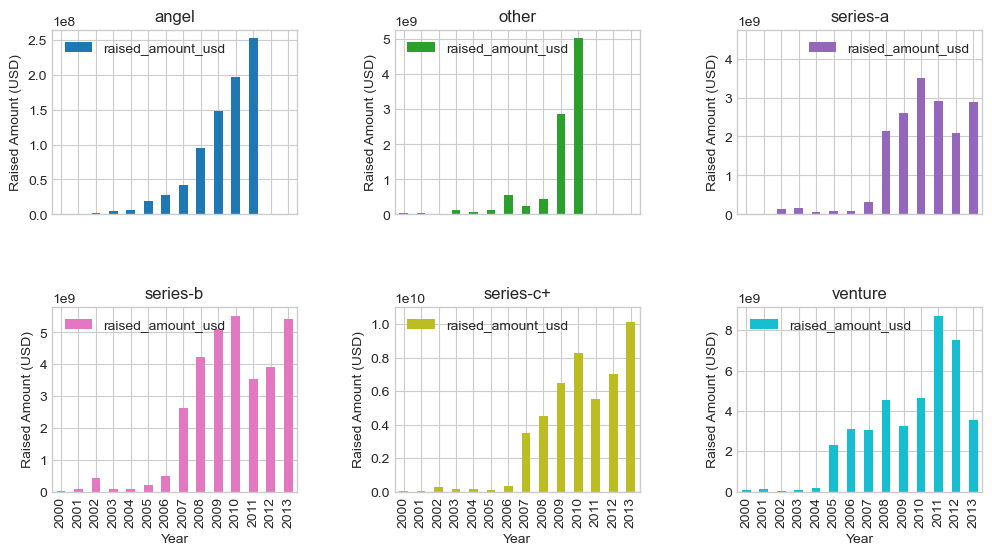

In [22]:
def plot_grouped_data(df: pd.DataFrame(),
                      groupby_column: str='funding_round_type',
                      n_cols: int=2) -> None:
    # determine the number of rows and columns for the subplots
    n_rows = int(len(df[groupby_column].unique()) / n_cols) + (len(df[groupby_column].unique()) % n_cols > 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6), sharex=True)
    grouped = df.groupby(groupby_column)

    # generate a list of unique colors for each group
    num_groups = len(df[groupby_column].unique())
    cmap = plt.get_cmap('tab10')
    colors = cmap(np.linspace(0, 1, num_groups))

    # iterate over the groups and plot the data on different axes with different colors
    for i, (name, group) in enumerate(grouped):
        ax = axs[i // n_cols, i % n_cols]
        group.plot(kind='bar', x='funded_at_year', y='raised_amount_usd', ax=ax, color=colors[i])
        ax.set_title(name)
        ax.set_xlabel('Year')
        ax.set_ylabel('Raised Amount (USD)')

    # remove empty subplots if the number of unique groups is not a multiple of n_cols
    if len(df[groupby_column].unique()) % n_cols != 0:
        for i in range(len(df[groupby_column].unique()), n_rows * n_cols):
            fig.delaxes(axs[i // n_cols, i % n_cols])

    plt.subplots_adjust(hspace=0.5, wspace=0.4)

    plt.show()

    
plot_grouped_data(df_round_type_year, 'funding_round_type', n_cols=3)

In [23]:
select_nth_rows_country_code = partial(select_nth_rows_per_round, 
                                       cols=['funding_round_id', 'country_code_investor_obj'])

top_10_countries_investment = (df_inv_cleaned
                                 .pipe(select_nth_rows_country_code)
                                 .groupby('country_code_investor_obj', as_index=False)
                                 .agg({'raised_amount_usd':'sum'})
                                 .query('raised_amount_usd != 0')
                                 .sort_values('raised_amount_usd', ascending=False)
                                 .reset_index(drop=True)
                                 .drop(2)
                                 .country_code_investor_obj.values[:8].to_list()
                                 #.astype('string')
                                )
top_10_countries_investment

['USA', 'GBR', 'CAN', 'ISR', 'FRA', 'DEU', 'CHE', 'CHN']

See the dynamics year over year for the top 10 countries.

In [24]:
df_country_code = (df_inv_cleaned
                     .pipe(select_nth_rows_country_code)
                     .assign(funded_at_year=lambda df_: df_.funded_at.dt.year,
                             country_code_investor_obj=lambda df_: (df_
                                                              .country_code_investor_obj
                                                              .astype('string')
                                                              .where(df_.country_code_investor_obj
                                                                     .isin(top_10_countries_investment), 'other')
                                                                   )
                            )
                     .groupby(['funded_at_year', 'country_code_investor_obj'])
                     .agg({'raised_amount_usd':'sum'})
                      # remove data for categories with 0 raised_amount_usd.
                     .query('raised_amount_usd != 0')
                     .reset_index()
                     .assign(funded_at_year=lambda df_: df_.funded_at_year.astype('int32'))
                    )

df_country_code.head()

,funded_at_year,country_code_investor_obj,raised_amount_usd
0,1997,USA,"5,000,000.00"
1,1998,USA,"27,800,000.00"
2,1999,FRA,"3,000,000.00"
3,1999,USA,"262,600,000.00"
4,1999,other,"14,000,000.00"


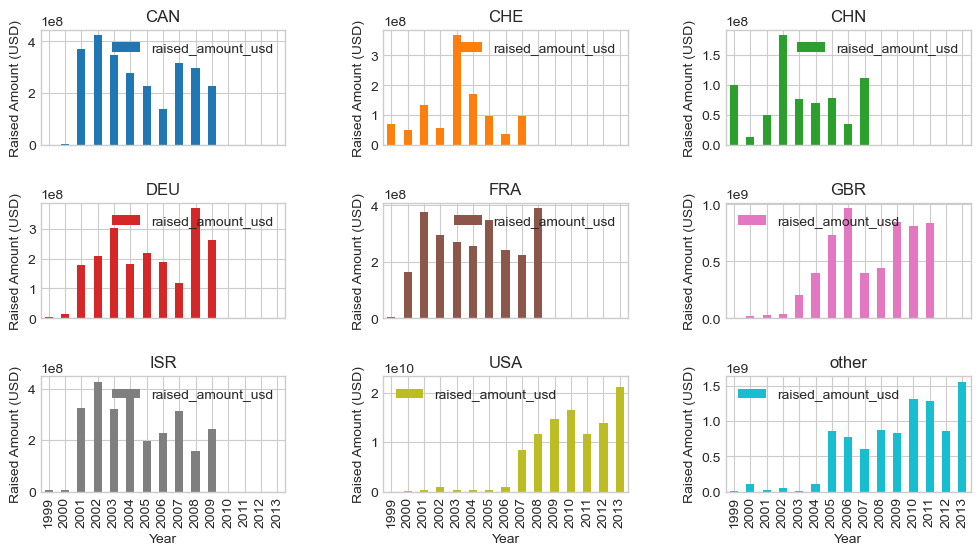

In [25]:
plot_grouped_data(df_country_code, 'country_code_investor_obj', n_cols=3)

In [26]:
!pip install pyarrow
def save_results(df: pd.DataFrame(), path: str, save_index: bool=False) -> None:
    df.to_parquet(path, index=save_index)
    
save_results(df_country_code, './output_data/investment_per_country.parquet')
save_results(df_round_type_year, './output_data/investment_per_round.parquet')
save_results(df_inv_cleaned, './output_data/investment_dataset.parquet')